In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from utils import SIR_net, SIR_net_adaptive, SIRS_net_adaptive
import utils
import multiprocessing as mp
import time

Testing the effect of rewiring in the information network

In [10]:
N = 10000 # number of nodes
ave_degree = 15
p = ave_degree / N  # edge probability
initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
initial_no_vax = np.arange(100,105)
#initial_no_vax = 300


mu = 0.1       # recovery rate
beta = 0.15    # infection rate
pro = 0.      # rate of classical media influence on people
pol = 0.2      # propensity of opinion polarization
p_sym = 0.     # prob for an infected person to have severe symptoms
r = 0.1        # rate of vaccination for PV
#gamma = 0.5
#nmax = 100

G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
G_info_static = G_phys.copy()
#utils.initNET_SI(G_info_static, I0=initial_no_vax, I_seed=np.arange(10)) # initialize information network
utils.initNET_rnd(G_info_static, initial_no_vax)
G_info_dynamic = G_info_static.copy()


sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, p_sym=p_sym, initial_infecteds=initial_infecteds, rewiring=False)
sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, p_sym=p_sym, initial_infecteds=initial_infecteds)

(0.0, 110.0)

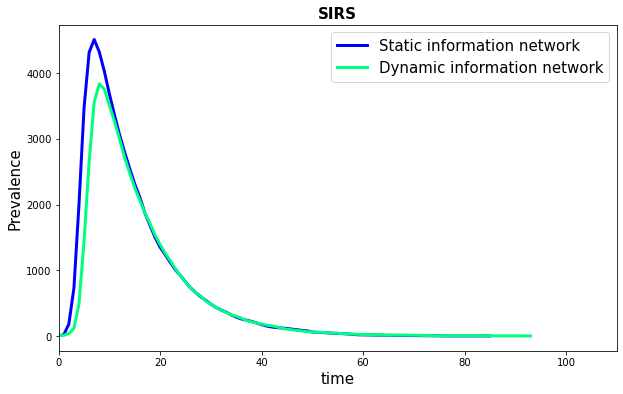

In [11]:
colors = cm.get_cmap('winter', 2)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
ax.plot(sim_static[0], sim_static[2], lw=3, c=colors(0), label= "Static information network", alpha=1)
ax.plot(sim_dynamic[0], sim_dynamic[2], lw=3, c=colors(1), label= "Dynamic information network", alpha=1)
ax.set_title('SIRS', fontweight='bold', size=15)
ax.legend(fontsize=15)
ax.set_ylabel("Prevalence", size=15)
ax.set_xlabel("time", size=15)
ax.set_xlim(0, 110)

infoNET clustering coefficients:
static: 0.008759809519415851
dynamic: 0.009080477741938164


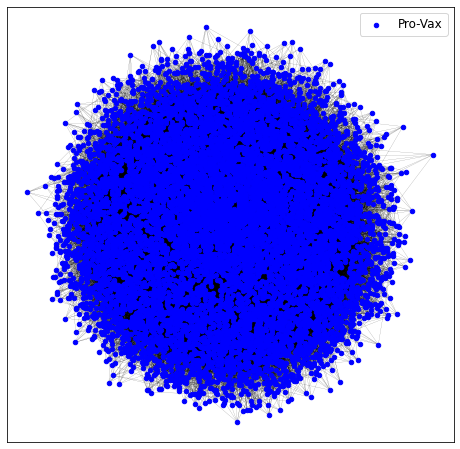

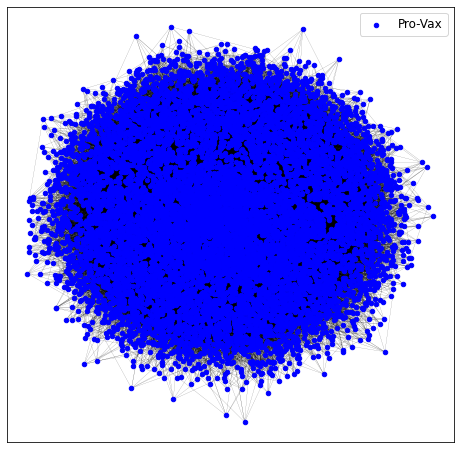

In [12]:
print('infoNET clustering coefficients:')
print('static:', nx.algorithms.cluster.average_clustering(G_info_static))
print('dynamic:', nx.algorithms.cluster.average_clustering(G_info_dynamic))
#utils.plot_info_network(G_info_static)
#utils.plot_info_network(G_info_dynamic)

In [13]:
vac = 0
rec = 0
for i in G_phys.nodes():
    if G_phys.nodes[i]['inf_status'] == 'V':
        vac += 1
    elif G_phys.nodes[i]['inf_status'] == 'R':
        rec += 1    
print('vaccinated', vac)
print('recovered', rec)

vaccinated 198
recovered 802


In [144]:
# Some more statistics
def sim_prevalence():
    N = 5000 # number of nodes
    ave_degree = 15
    p = ave_degree / N  # edge probability
    initial_infecteds = np.random.choice(np.arange(N), size=5, replace=False)
    initial_no_vax = np.arange(100,300)


    mu = 0.1       # recovery rate
    beta = 0.15    # infection rate
    pro = 0.      # rate of classical media influence on people
    pol = 0.5      # propensity of opinion polarization
    p_sym = 0.     # prob for an infected person to have severe symptoms
    r = 0.3       # rate of vaccination for PV

    G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
    G_info_static = G_phys.copy()
    utils.initNET_rnd(G_info_static, initial_no_vax)
    G_info_dynamic = G_info_static.copy()
    seed = np.random.randint(time.time())

    sim_static = SIR_net_adaptive(G_phys, G_info_static, beta=beta, mu=mu, r=r, pro=pro, pol=pol, p_sym=p_sym, initial_infecteds=initial_infecteds, rewiring=False, message=False, seed=seed)
    sim_dynamic = SIR_net_adaptive(G_phys, G_info_dynamic, beta=beta, mu=mu, r=r, pro=pro, pol=pol, p_sym=p_sym, initial_infecteds=initial_infecteds, message=False, seed=seed)
    print('simulation completed')
    return (sim_static, sim_dynamic)

In [145]:
nsim = 16
answers = []
pool = mp.Pool(mp.cpu_count())

results = [pool.apply_async(sim_prevalence) for _ in range(nsim)]
answers = [res.get(timeout=180) for res in results]
pool.close()

simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed
simulation completed


In [146]:
answers = np.array(answers, dtype=object)
static_I = answers[:, 0, [0,2]]
dynamic_I = answers[:, 1, [0,2]]
minlen_static_I = min(list(map(len, static_I[:,1])))
minlen_dynamic_I = min(list(map(len, dynamic_I[:,1])))
ave_I_stat = np.mean([static_I[i,1][:minlen_static_I] for i in range(nsim)], axis=0)
ave_I_dyn = np.mean([dynamic_I[i,1][:minlen_dynamic_I] for i in range(nsim)], axis=0)

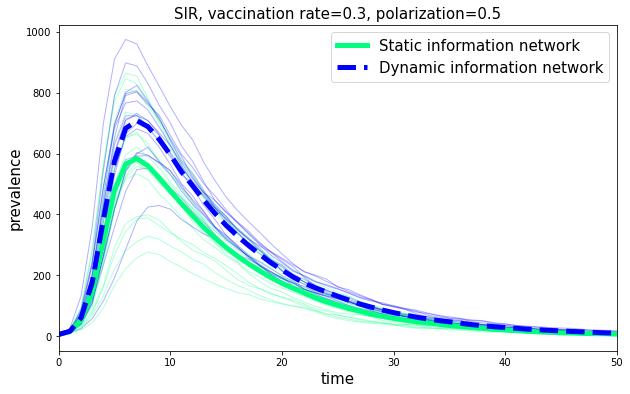

In [147]:
r = 0.3
pol = 0.5
colors = cm.get_cmap('winter', 2)
plt.figure(figsize=(10,6))
plt.title(f'SIR, vaccination rate={r}, polarization={pol}', size=15)
plt.xlabel('time', size=15)
plt.ylabel('prevalence', size=15)
for curve1, curve2 in zip(static_I, dynamic_I):
    plt.plot(curve1[0], curve1[1], c=colors(1), lw=1, alpha=0.3)
    plt.plot(curve2[0], curve2[1], c=colors(0), lw=1, alpha=0.3)
plt.plot(np.arange(minlen_static_I), ave_I_stat, lw=5, c=colors(1), label='Static information network')
plt.plot(np.arange(minlen_dynamic_I), ave_I_dyn, lw=5, c=colors(0), label='Dynamic information network', ls='dashed')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,50)
plt.savefig(f'./plots/SIR_r{r}_pol{pol}_v1.png')

Testing if with a faster dynamics we can appreciate differences among curves with this second scheme

In [26]:
N = 1000 # number of nodes
ave_degree = 15
p = ave_degree / N  # edge probability
initial_infecteds = np.random.choice(np.arange(N), size=100, replace=False)

mu = 0.1       # recovery rate
beta = 0.15    # infection rate
pro = 0.05       # rate of classical media influence on people
pol = 0.5       # propensity of opinion polarization
p_sym = 0.05    # prob for an infected person to have severe symptoms
r = 0.1         # rate of vaccination for PV


G_phys = nx.barabasi_albert_graph(N, int(ave_degree/2))
G_info_0 = G_phys.copy()
G_info_50 = G_phys.copy()
G_info_100 = G_phys.copy()
G_info_300 = G_phys.copy()
utils.initNET_SI(G_info_0, I0=0, I_seed=[])
utils.initNET_SI(G_info_50, I0=50, I_seed=np.arange(10))
utils.initNET_SI(G_info_100, I0=100, I_seed=np.arange(10))
utils.initNET_SI(G_info_300, I0=300, I_seed=np.arange(10))

sim1 = SIR_net(G_phys, beta=beta, mu=mu, initial_infecteds=initial_infecteds)
sim2 = SIR_net_adaptive(G_phys, G_info_0, beta=beta, mu=mu, r=r, pro=pro, pol=pol, p_sym=p_sym, initial_infecteds=initial_infecteds)
sim3 = SIR_net_adaptive(G_phys, G_info_50, beta=beta, mu=mu, r=r, pro=pro, pol=pol, p_sym=p_sym, initial_infecteds=initial_infecteds)
sim4 = SIR_net_adaptive(G_phys, G_info_100, beta=beta, mu=mu, r=r, pro=pro, pol=pol, p_sym=p_sym, initial_infecteds=initial_infecteds)
sim5 = SIR_net_adaptive(G_phys, G_info_300, beta=beta, mu=mu, r=r, pro=pro, pol=pol, p_sym=p_sym, initial_infecteds=initial_infecteds)

(0.0, 50.0)

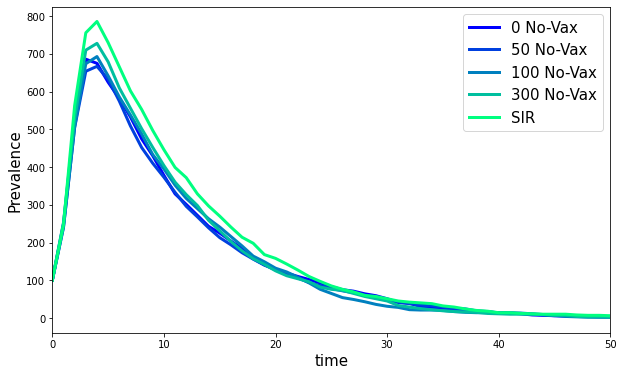

In [27]:
colors = cm.get_cmap('winter', 5)
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
ax.plot(sim2[0], sim2[2], lw=3, c=colors(0), label= "0 No-Vax", alpha=1)
ax.plot(sim3[0], sim3[2], lw=3, c=colors(1), label= "50 No-Vax", alpha=1)
ax.plot(sim4[0], sim4[2], lw=3, c=colors(2), label= "100 No-Vax", alpha=1)
ax.plot(sim5[0], sim5[2], lw=3, c=colors(3), label= "300 No-Vax", alpha=1)
ax.plot(sim1[0], sim1[2], lw=3, c=colors(4), label= "SIR", alpha=1)
ax.legend(fontsize=15)
ax.set_ylabel("Prevalence", size=15)
ax.set_xlabel("time", size=15)
ax.set_xlim(0,50)

In [28]:
print('total infected with 0 novax:', sim2[4])
print('total infected with 50 novax:', sim3[4])
print('total infected with 100 novax:', sim4[4])
print('total infected with 300 novax:', sim5[4])

total infected with 0 novax: 846
total infected with 50 novax: 865
total infected with 100 novax: 879
total infected with 300 novax: 923
